In [294]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
import mygene
from scipy.stats import zscore

# Analysis of GTEx vs TCGA (Pairwise)

Using data produced from this experiment: <br>
https://github.com/jvivian/rnaseq-recompute-analysis/blob/master/experiments/pairwise_gtex_vs_tcga.py

## Number of samples

In [205]:
def zip_sort(x, y):
    vals = sorted(zip(x, y), key=lambda x: x[1])
    return zip(*vals)

def label_fix(l):
    return [x.replace('_', '\n').capitalize() for x in l]

def plot_overlap(d, d2, tissues):
    '''d is a dictionary with tissue as key and value as number'''
    overlap = []
    for tissue in tissues:
        n = len(d[tissue]) if len(d[tissue]) > 0 else 0.1
        overlap.append([float(len(set(d[tissue]).intersection(set(d2[x]))))/n for x in tissues])

    overlap = pd.DataFrame(overlap)
    overlap.index = label_fix(tissues)
    overlap.columns = label_fix(tissues)

    fig, ax = plt.subplots(figsize=[12,10])
    sns.heatmap(overlap, ax=ax, cmap='Blues')
    plt.title('Top {} Gene Overlap Between Tissues'.format(n));

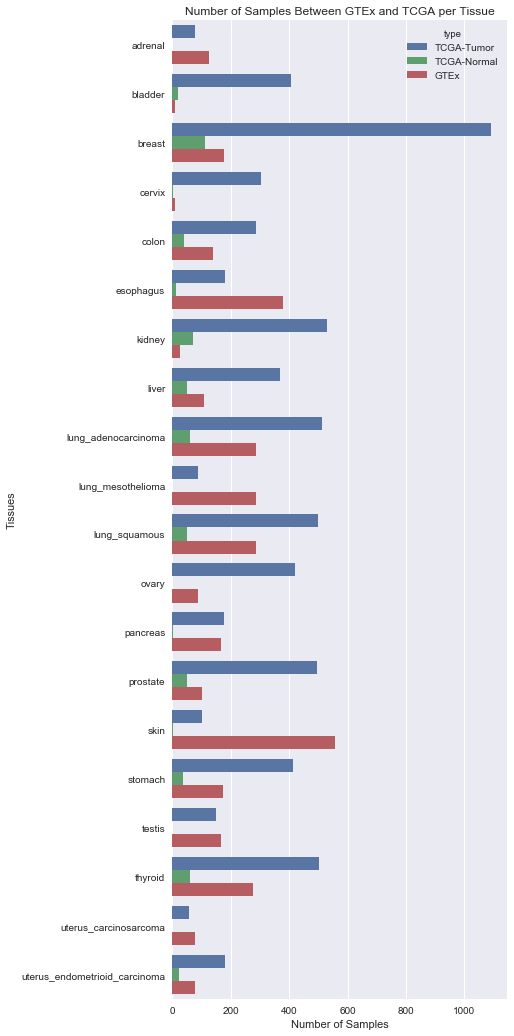

In [277]:
# Ugly list of samples b/c the experiment output is 20G so I did it server side
df = pd.DataFrame()
tissues = set([x.split('-')[0] for x in os.listdir('results/')])
df['tissues'] = sorted([x for x in tissues for _ in (0,1,2)])
df['type'] = ['TCGA-Tumor', 'TCGA-Normal', 'GTEx'] * (len(df.tissues) / 3)
df['num_samples'] = [77, 0, 125, 
                     407, 19, 9, 
                     1092, 113, 178, 
                     303, 3, 10, 
                     287, 41, 140, 
                     181, 13, 379, 
                     530, 72, 27, 
                     369, 50, 110, 
                     513, 59, 287, 
                     87, 0, 287, 
                     498, 50, 287, 
                     420, 0, 88, 
                     178, 4, 165, 
                     494, 51, 100, 
                     102, 1, 556, 
                     413, 36, 173, 
                     148, 0, 165, 
                     504, 59, 278, 
                     57, 0, 78, 
                     180, 23, 78]

f, ax = plt.subplots(figsize=(6, 18))
# sns.barplot('tissues', 'num_samples', hue='type', ax=ax, data=df)
sns.barplot('num_samples', 'tissues', hue='type', ax=ax, data=df)
plt.xlabel('Number of Samples')
plt.ylabel('Tissues')
plt.title('Number of Samples Between GTEx and TCGA per Tissue');

# Results

In [306]:
results = {}
tissues = sorted(list(set([x.replace('\n', '_').lower() for x in df.tissues])))
for result in tissues:
    results[result] = pd.read_csv('results/' + result + '-results.tsv', index_col=0, sep='\t')
    results[result]['pval_count_percentage'] = results[result]['pval_counts'] / results[result]['num_samples']
    
results_norm = {}
for result in tissues:
    results_norm[result] = pd.read_csv('results/' + result + '-normal-results.tsv', index_col=0, sep='\t')
    results_norm[result]['pval_count_percentage'] = results_norm[result]['pval_counts'] / results_norm[result]['num_samples']
    
result_paths = [x for x in os.listdir('../tcga-tumor-vs-normal/results') if '.tsv' in x]
results_tcga = {}
for result in result_paths:
    results_tcga[result.split('-')[0]] = pd.read_csv(os.path.join('../tcga-tumor-vs-normal/results', result), index_col=0, sep='\t')

result_paths = [x for x in os.listdir('../tcga-matched/results') if '.tsv' in x]
results_matched = {}
for result in result_paths:
    results_matched[result.split('-')[0]] = pd.read_csv(os.path.join('../tcga-matched/results', result), index_col=0, sep='\t')

#### Plot of Pval Counts by Tissue for all Genes

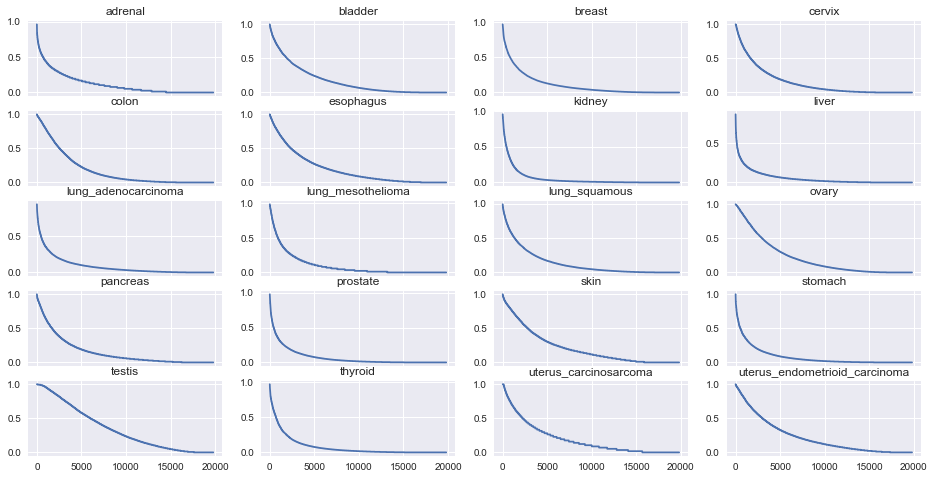

In [307]:
tissue_2d = np.reshape(np.array(tissues), (5, 4))
f, axes = plt.subplots(5, 4, figsize=(16, 8), sharex=True)
for i in xrange(5):
    for j in xrange(4):
        try:
            tissue_df = results[tissue_2d[i][j]]
            axes[i][j].plot([x for x in xrange(len(tissue_df.pval_counts))], tissue_df.pval_count_percentage)
            axes[i][j].set_title(tissue_2d[i][j])
        except:
            pass

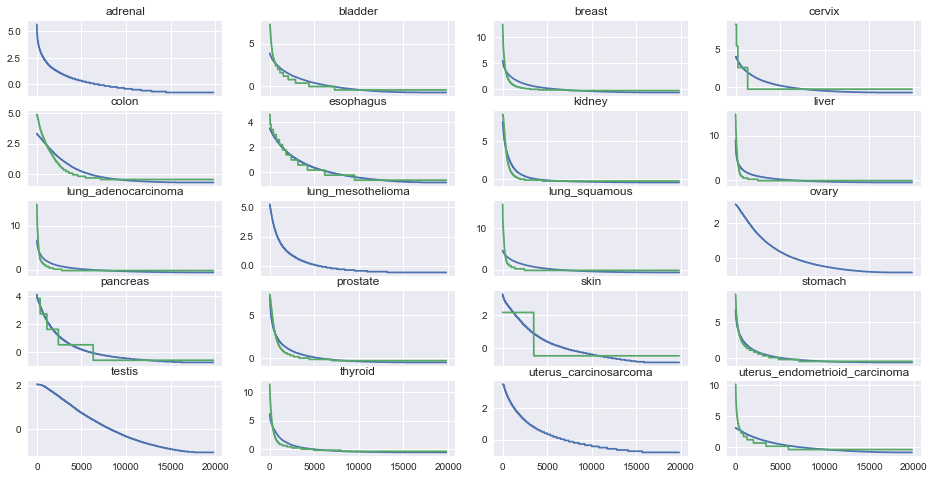

In [301]:
tissue_2d = np.reshape(np.array(tissues), (5, 4))
f, axes = plt.subplots(5, 4, figsize=(16, 8), sharex=True)
for i in xrange(5):
    for j in xrange(4):
        tissue_df = results[tissue_2d[i][j]]
        axes[i][j].plot([x for x in xrange(len(tissue_df.pval_counts))], zscore(tissue_df.pval_counts))
        axes[i][j].set_title(tissue_2d[i][j])
        try:
            tissue_df = results_norm[tissue_2d[i][j]]
            axes[i][j].plot([x for x in xrange(len(tissue_df.pval_counts))], zscore(tissue_df.pval_counts))
        except:
            pass

### Significant Genes

Let's consider a gene significant if it was significantly differentially expressed in 90% of our samples. Although this number may change if it's too stringent.

For example, bladder has 407 TCGA primary tumor samples to compare against, so we'll be looking at genes that have a pvalue count of at least 366.

In [278]:
results['bladder'].head()

,num_samples,pval_counts,pval,pval_std,fc,fc_std,gene_id
CALCOCO1,407,407,5.374780e-17,0.0000,-2.2721,0.5696,ENSG00000012822.15
RPN1,407,406,8.603706e-18,0.0035,2.0333,0.4723,ENSG00000163902.11
CELA3A,407,406,4.488333e-07,0.0261,-6.7758,0.9556,ENSG00000142789.19
PNLIP,407,405,6.929615e-07,0.0329,-6.7702,0.8777,ENSG00000175535.6
CALR,407,404,7.696320e-10,0.0035,2.4475,0.5389,ENSG00000179218.13


Positive log2FoldChange are gain of function for TCGA <br>
Negative log2FoldChange are loss of function for GTEx

### FC vs Pval Count

Plot the relationship between FC and pval_count. We would expect to see a bimodal plot, where higher fold change values are correlated with pval_count.

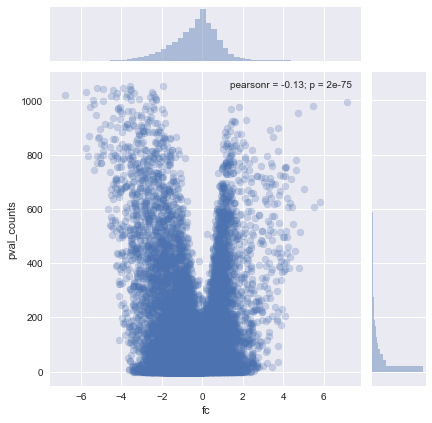

In [303]:
t = results['breast']
sns.jointplot(t.fc, t.pval_counts, alpha=0.25);

## Significant gene plots

In [260]:
n = 100
sig_genes_up = {}
sig_genes_down = {}
top_genes_up = {}
top_genes_down = {}
for t in tissues:
    num_samples = results[t].num_samples.mean()
    cutoff = num_samples * 0.90
    
    df_up = results[t][results[t].fc > 0]
    df_down = results[t][results[t].fc < 0]
    
    top_genes_up[t] = set(df_up.head(n).index)
    top_genes_down[t] = set(df_down.head(n).index)
    
    sig_genes_up[t] = set(df_up[df_up.pval_counts > cutoff].index)
    sig_genes_down[t] = set(df_down[df_down.pval_counts > cutoff].index)

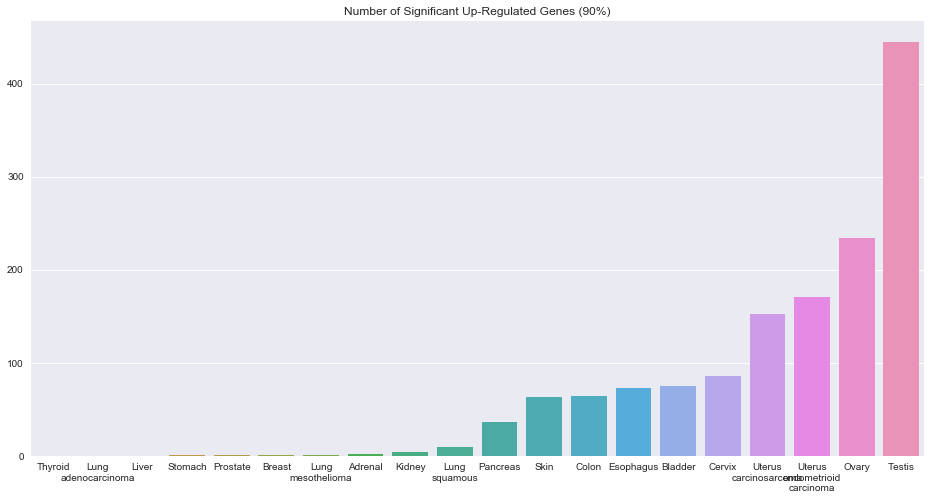

In [261]:
f, ax = plt.subplots(figsize=(16,8))
x, y = zip_sort(sig_genes_up.keys(), [len(sig_genes_up[x]) for x in sig_genes_up.keys()])
sns.barplot(label_fix(x), y)
plt.title('Number of Significant Up-Regulated Genes (90%)');

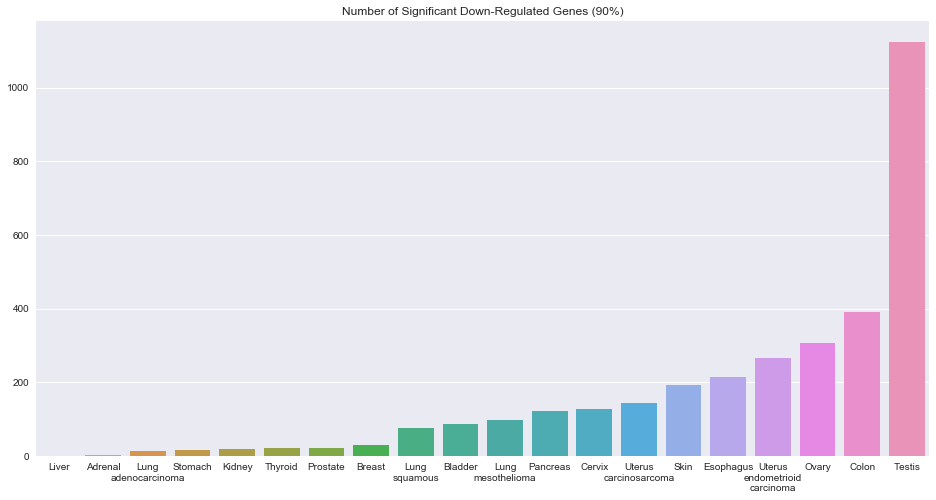

In [263]:
f, ax = plt.subplots(figsize=(16,8))
x, y = zip_sort(sig_genes_down.keys(), [len(sig_genes_down[x]) for x in sig_genes_down.keys()])
sns.barplot(label_fix(x), y)
plt.title('Number of Significant Down-Regulated Genes (90%)');

### Correlation Between Number of GTEx / TCGA Samples and Significant Genes

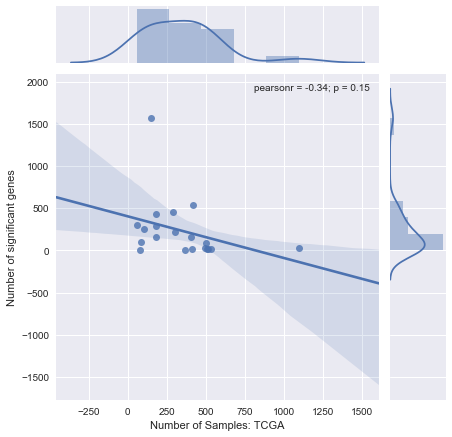

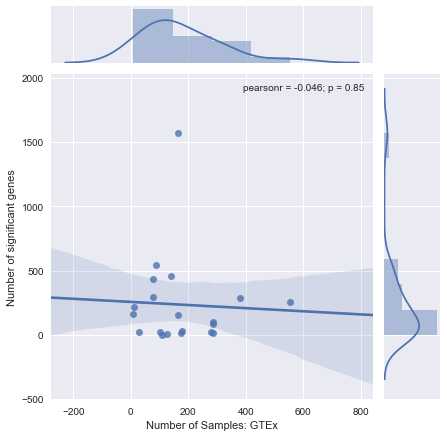

In [180]:
for t in ['TCGA', 'GTEx']:
    num_samples = np.array(df[df['type'] == t].num_samples)
    num_sig = np.array([len(sig_genes_up[x]) + len(sig_genes_down[x]) for x in tissues])
    sns.jointplot(num_samples, num_sig, kind='reg')
    plt.xlabel('Number of Samples: ' + t)
    plt.ylabel('Number of significant genes')
    

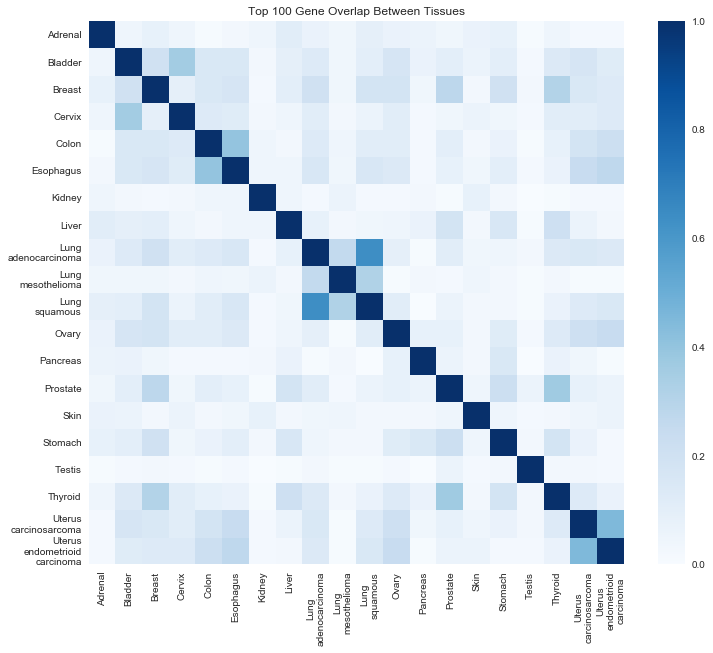

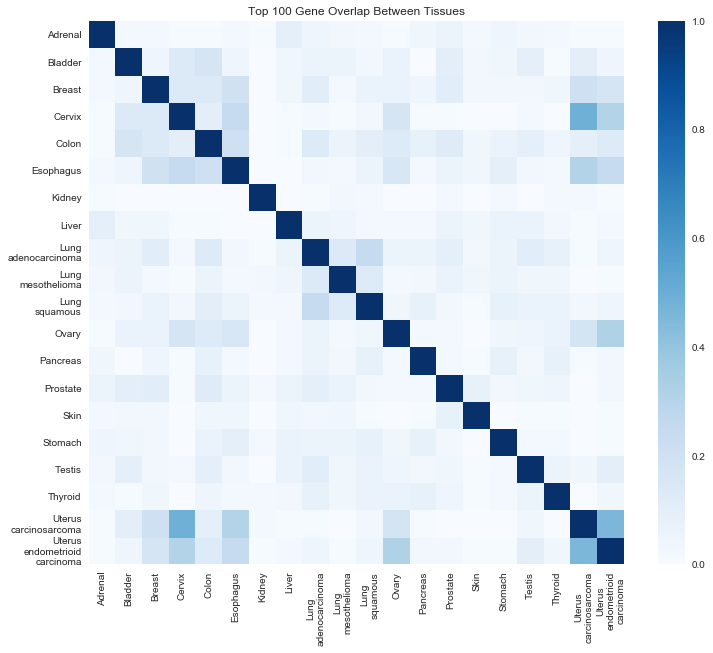

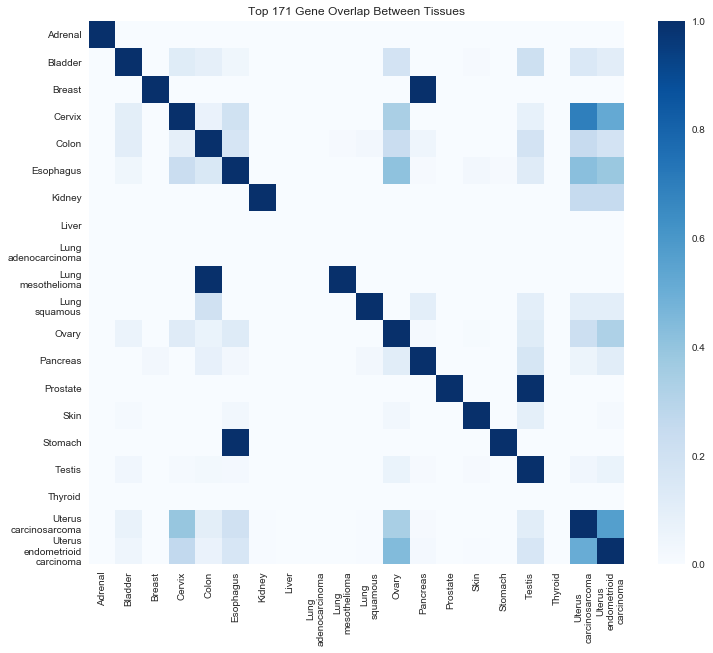

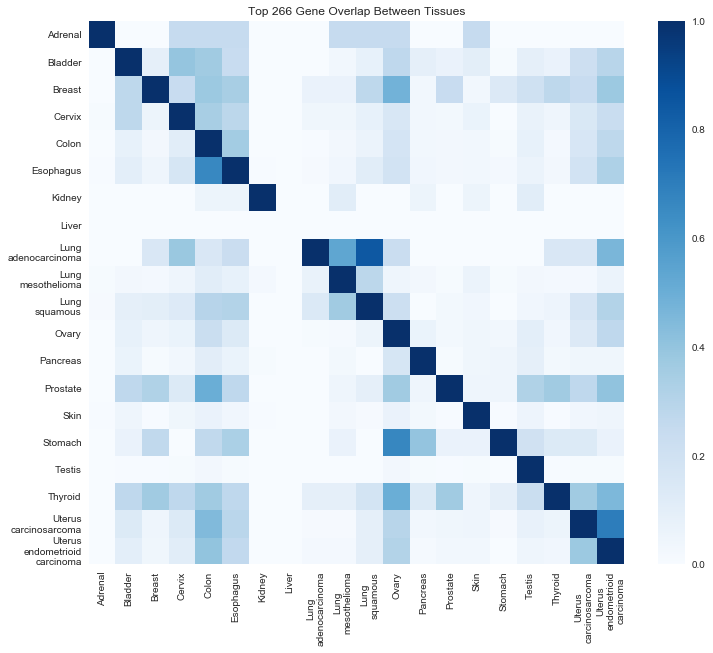

In [190]:
for group in [top_genes_down, top_genes_up, sig_genes_up, sig_genes_down]:
    plot_overlap(group, group)

### Overlap between TCGA TvN, TCGA Matched, and Pairwise

In [227]:
n = 100
tcga_top_up = {}
tcga_top_down = {}
match_top_up = {}
match_top_down = {}
for t in tissues:
    try:
        df_up = results_tcga[t][results_tcga[t].log2FoldChange > 0]
        df_down = results_tcga[t][results_tcga[t].log2FoldChange < 0]
    
        tcga_top_up[t] = set(df_up.head(n).index)
        tcga_top_down[t] = set(df_down.head(n).index)
        
        df_up = results_matched[t][results_matched[t].log2FoldChange > 0]
        df_down = results_matched[t][results_matched[t].log2FoldChange < 0]
        
        match_top_up[t] = set(df_up.head(n).index)
        match_top_down[t] = set(df_down.head(n).index)
    except KeyError:
        pass

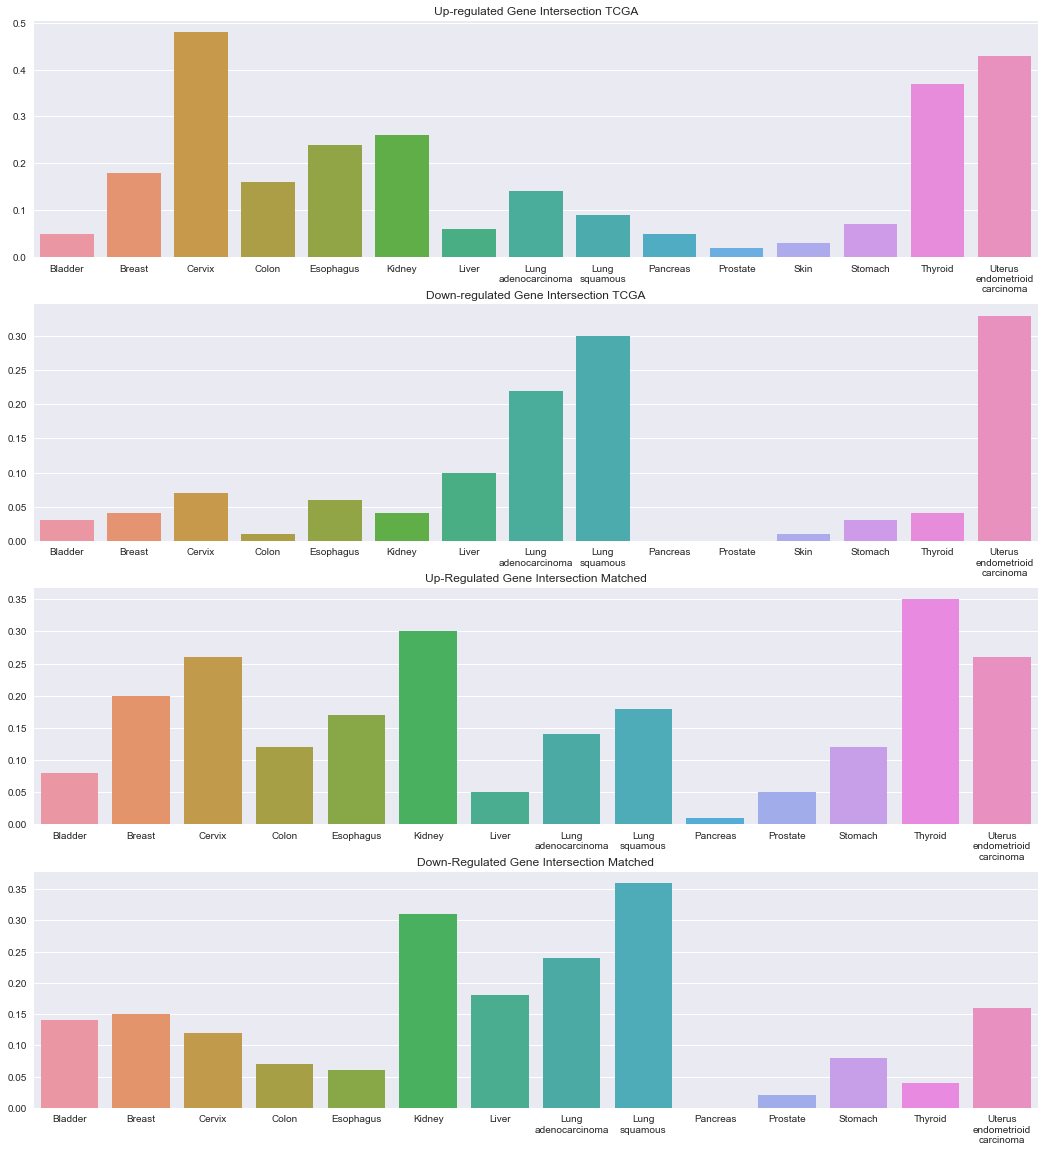

In [238]:
inter_up_tcga = []
inter_down_tcga = []
inter_up_match = []
inter_down_match = []
for t in sorted(tcga_top_down.keys()):
    inter_up_tcga.append( len(top_genes_up[t].intersection(tcga_top_up[t]))*1.0 / n )
    inter_down_tcga.append( len(top_genes_down[t].intersection(tcga_top_down[t]))*1.0 / n )
    try:
        inter_up_match.append(len(top_genes_up[t].intersection(match_top_up[t]))*1.0 / n )
        inter_down_match.append( len(top_genes_down[t].intersection(match_top_down[t]))*1.0 / n )
    except: pass

f, ax = plt.subplots(4, figsize=(18,20))
sns.barplot(label_fix(sorted(tcga_top_down.keys())), inter_up, ax=ax[0])
ax[0].set_title('Up-regulated Gene Intersection TCGA')

sns.barplot(label_fix(sorted(tcga_top_down.keys())), inter_down, ax=ax[1])
ax[1].set_title('Down-regulated Gene Intersection TCGA')

sns.barplot(label_fix(sorted(match_top_down.keys())), inter_up_match, ax=ax[2])
ax[2].set_title('Up-Regulated Gene Intersection Matched')

sns.barplot(label_fix(sorted(match_top_down.keys())), inter_down_match, ax=ax[3])
ax[3].set_title('Down-Regulated Gene Intersection Matched')


### Write out values

In [239]:
try:
    os.mkdir('analysis')
    os.mkdir('analysis/sig-genes')
    os.mkdir('analysis/top-100-genes')
    os.mkdir('analysis/annotations')
except OSError:
    pass

In [240]:
for t in tissues:
    up_genes = top_genes_up[t]
    down_genes = top_genes_down[t]
    sig_up = sig_genes_up[t]
    sig_down = sig_genes_down[t]
    
    with open('analysis/top-100-genes/' + t + '-upreg.txt', 'w') as f:
        f.write('\n'.join(up_genes))
    with open('analysis/top-100-genes/' + t + '-downreg.txt', 'w') as f:
        f.write('\n'.join(down_genes))
    with open('analysis/sig-genes/' + t + '-upreg.txt', 'w') as f:
        f.write('\n'.join(sig_up))
    with open('analysis/sig-genes/' + t + '-downreg.txt', 'w') as f:
        f.write('\n'.join(sig_down))


## Cancer Predisposition Intersect

In [247]:
cpg = pd.read_csv('../tcga-tumor-vs-normal/cancer_predisoposition_genes.tsv', sep='\t')
cp_genes = set(cpg.gene)
cpg_up = cpg[cpg.mechanism == 'gain-of-function']
cpg_down = cpg[cpg.mechanism == 'loss-of-function']
print len(cpg_up), len(cpg_down)

15 114


In [248]:
n = 500
up_intersect = []
down_intersect = []
for t in tissues:
    df = results[t]
    up_genes = df[df.fc > 0].head(n).index
    down_genes = df[df.fc < 0].head(n).index
    
    up_intersect.append(len(set(cpg_up.gene).intersection(set(up_genes))))
    down_intersect.append(len(set(cpg_down.gene).intersection(set(down_genes))))

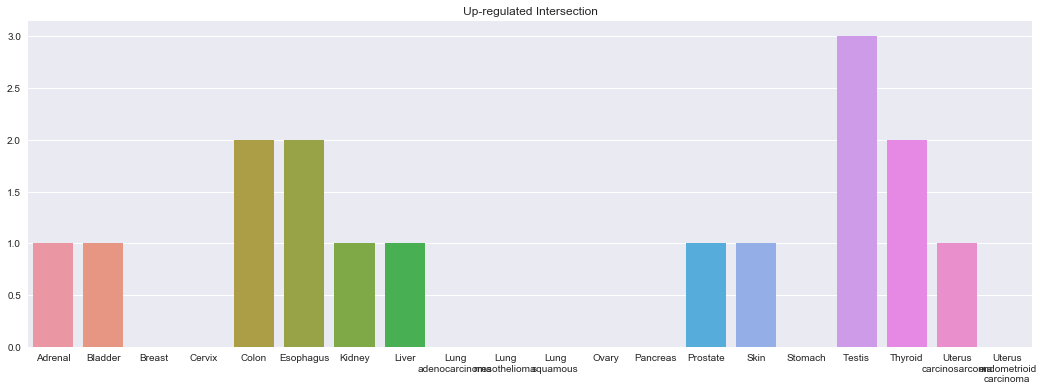

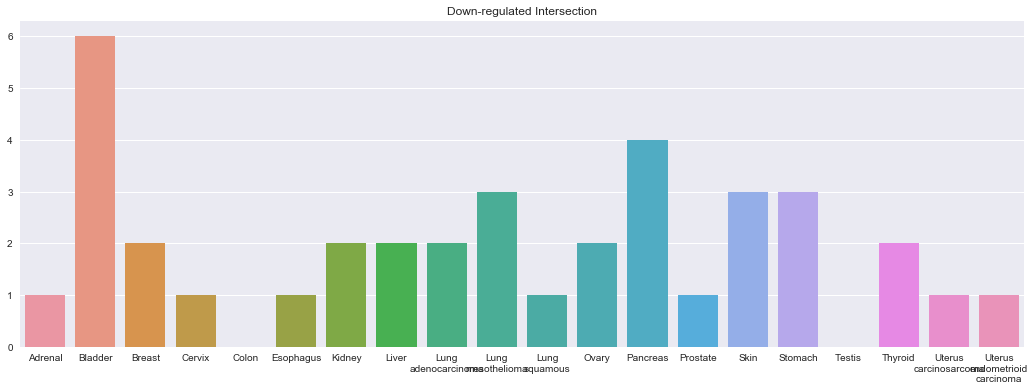

In [250]:
fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(label_fix(tissues), up_intersect, ax=ax)
plt.title('Up-regulated Intersection')
plt.show()

fig, ax = plt.subplots(figsize=[18,6])
sns.barplot(label_fix(tissues), down_intersect, ax=ax)
plt.title('Down-regulated Intersection');

## Annotations

In [242]:
def get_basic_gene_info(gene_list):
    mg = mygene.MyGeneInfo()
    return mg.querymany(gene_list, 
                        scopes='symbol', 
                        fields='symbol,name,entrezgene,summary', 
                        species='human', 
                        returnall=True, 
                        as_dataframe=True, 
                        size=1)

In [243]:
annotations_path = 'analysis/annotations'
for t in tissues:
    upreg = top_genes_up[t]
    downreg = top_genes_down[t]
    # Query gene server
    up_info = get_basic_gene_info(upreg)
    up_info['out'].to_csv(os.path.join(annotations_path, t + '-up-annotations.tsv'), sep='\t')
    down_info = get_basic_gene_info(downreg)
    down_info['out'].to_csv(os.path.join(annotations_path, t + '-down-annotations.tsv'), sep='\t')        

querying 1-100...done.
Finished.
2 input query terms found no hit:
	[u'TCEB2', u'WIBG']
querying 1-100...done.
Finished.
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'SHFM1']
querying 1-100...done.
Finished.
2 input query terms found no hit:
	[u'PPAP2B', u'RP11-574K11.31']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'SGOL2']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'AC009336.19']
querying 1-100...done.
Finished.
2 input query terms found no hit:
	[u'KIAA0101', u'CASC5']
querying 1-100...done.
Finished.
2 input query terms found no hit:
	[u'RP11-574K11.31', u'C1orf95']
querying 1-100...done.
Finished.
querying 1-100...done.
Finished.
querying 1-100...done.
Finished.
3 input query terms found no hit:
	[u'C10orf12', u'CASC5', u'MLK4']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'PPAPDC3']
querying 1-100...done.
Finished.
1 input query terms found no hit:
	[u'KIAA1715']
querying 1-100.